<a href="https://colab.research.google.com/github/bandofpv/USNA-Robotics-Courses/blob/main/EW442/Project_7/Project_7_Shallow_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EW 442: Data Science and AI**

## **Project 7: Shallow Neural Networks for College Admissions (Google Colab Version)**

*Using only two numerical predictors can we predict if students will be admitted or rejected from America's best college?*

# **Goals**

* **Build** a shallow neural network classifier using `scikit-learn`'s `MLPClassifier`.
* **Evaluate** model performance using confusion matrices, accuracy, precision, and recall.
* **Visualize** decision boundaries to understand how the network separates classes.
* **Experiment** with hidden-layer size, noise, data quantity, and decision thresholds.

# **Part 1: Basic NN Workflow**

## **Step 0. Setup**

In Google Colab, helper files cannot be imported directly from a local `.py` file. Instead, we embed the helper functions directly in the notebook. The cell below contains two functions from the original `admissions_helpers.py`:

* `fake_admissions_data(N, noise_level, rng=None)` -- generates CFA and SAT data and labels.
* `visualize_boundary(model, X, y, threshold=0.5, test_idx=None)` -- plots decision regions and overlays test predictions.

1. **Create a New Notebook:** Name it `EW442_Project7_Lastname`.
2. **Embed Helper Functions:** Run the following code block to define the helper functions.

In [1]:
# -- Helper functions (embedded for Google Colab) --------------------------
# In a local Anaconda/Jupyter setup these would be imported from
# admissions_helpers.py.  Google Colab cannot import local .py files
# directly, so the full source code is included here instead.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def fake_admissions_data(N: int, noise_level: float, rng=None):
    """Generate admissions toy data.

    Features:
        CFA in [50, 100]
        SAT in [800, 1600]

    Ground-truth label rule (before noise):
        ACCEPT (1) if SAT >= -7*CFA + 1800, else REJECT (0).

    Noise:
        Multiplicative per feature in [(1-noise_level), (1+noise_level)],
        then clamp to valid ranges and round to integers.

    Returns
    -------
    X : (N, 2) ndarray, columns [CFA, SAT] (ints)
    y : (N,) ndarray of {0, 1} where 1=ACCEPT
    """
    rng = np.random.default_rng(rng)
    # Base features
    CFA = 50 + 50 * rng.random(N)        # [50,100]
    SAT = 800 + 800 * rng.random(N)      # [800,1600]

    # Labels (linearly separable rule: accept if SAT >= -7*CFA + 1800)
    y = (SAT >= (-7 * CFA + 1800)).astype(int)

    # Multiplicative noise per feature in [(1-noise), (1+noise)]
    noise = (1 - noise_level) + (2 * noise_level) * rng.random((N, 2))
    CFA_noisy = CFA * noise[:, 0]
    SAT_noisy = SAT * noise[:, 1]

    # Respect limits, then round to integers
    CFA_noisy = np.clip(CFA_noisy, 0, 100)
    SAT_noisy = np.clip(SAT_noisy, 0, 1600)
    CFA_noisy = np.round(CFA_noisy).astype(int)
    SAT_noisy = np.round(SAT_noisy).astype(int)

    X = np.column_stack([CFA_noisy, SAT_noisy])
    return X, y


def visualize_boundary(model, X, y, threshold: float = 0.5, test_idx=None, npts: int = 40):
    """Plot decision regions and overlay test predictions.

    Parameters
    ----------
    model : fitted estimator supporting predict_proba(X) -> P(class=1)
            (Pipelines with scalers are supported.)
    X : (N,2) ndarray of raw features [CFA, SAT]
    y : (N,) ndarray of true labels {0,1}
    threshold : float in [0,1], decision threshold for class 1
    test_idx : array-like of indices belonging to the test split (optional)
    npts : int, resolution of the meshgrid
    """
    X = np.asarray(X)
    y = np.asarray(y).astype(int)

    # Mesh over data range
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, npts),
                         np.linspace(y_min, y_max, npts))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Region prediction using threshold on P(class=1)
    probs = model.predict_proba(grid)[:, 1]
    region = (probs > threshold).astype(int).reshape(xx.shape)

    # Plot decision regions (light red=reject, light green=accept)
    cmap_bg = ListedColormap([[1.0, 0.85, 0.85], [0.85, 1.0, 0.85]])
    plt.figure()
    plt.pcolormesh(xx, yy, region, shading='auto', cmap=cmap_bg)

    # Original data (dots): red=reject(0), green=accept(1)
    plt.scatter(X[y==1,0], X[y==1,1], c='g', label='ACCEPT (truth)', edgecolor='k', s=28)
    plt.scatter(X[y==0,0], X[y==0,1], c='r', label='REJECT  (truth)', edgecolor='k', s=28)

    # Test predictions as open circles (color by predicted class at 0.5)
    if test_idx is not None and len(test_idx) > 0:
        test_idx = np.asarray(test_idx, dtype=int)
        probs_test = model.predict_proba(X[test_idx])[:, 1]
        yhat_test = (probs_test > 0.5).astype(int)
        plt.scatter(X[test_idx][yhat_test==1,0], X[test_idx][yhat_test==1,1],
                    facecolors='none', edgecolors='g', s=80, label='ACCEPT (pred, test)')
        plt.scatter(X[test_idx][yhat_test==0,0], X[test_idx][yhat_test==0,1],
                    facecolors='none', edgecolors='r', s=80, label='REJECT  (pred, test)')

    plt.xlabel('CFA')
    plt.ylabel('SAT')
    plt.title('USNA Admissions: Decision Regions & Test Predictions')
    plt.legend(loc='upper right', framealpha=0.9)
    plt.tight_layout()
    plt.show()

3. **Import Required Libraries:** Run the cell below to import the remaining libraries.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

---
## **Step 1: Create Admissions Data**

Read the documentation inside the helper function cell above for `fake_admissions_data` (the function docstring). Now create an initial dataset with exactly N = 50 students and noise_level = 0 (no noise). Use a fixed seed and record it.

In [3]:
seed = 42
N = 50
noise_level = 0.0
X, y = fake_admissions_data(N, noise_level, rng=seed)

**Q1.** Add a brief note explaining the format of the dataset (columns and labels) and its source (the helper function). Comment on how balanced is the data set between Admitted and Rejected students.

> **Answer:**
>
>The dataset has three columns: CFA scores (int), SAT scores (int), and Accepted ([0=Rejected or 1=Accepted). The dataset is produced by the fake_admissions_data() function which accepts the number of students in the dataset, the noise level, and the random seed. It then calculates a random CFA score bounded between 50-100 and a random SAT score bounded by 800-1600. Both random scores are produced using the provided random seed. To calculate whether or not the student is labeled as accepted or rejected, it uses the following function: accept if SAT >= -7*CFA + 1800. Finally it adds random noise to the CFA and SAT scores while maintaining within the bounds of possible scores. The dataset produced 17 acceptances and 33 rejected. So the dataset is skewed with a 34% acceptance rate.

---
## **Step 2: Visualize Data**

Write code to visualize the data in a scatter plot with the CFA-score on the x-axis, the SAT score on the y-axis, and using different color dots for admitted vs rejected students. Add a legend.

HINT: use `matplotlib.pyplot.scatter` with a boolean mask for groups (y==1 vs y==0). The first two lines could look like:

```python
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
```

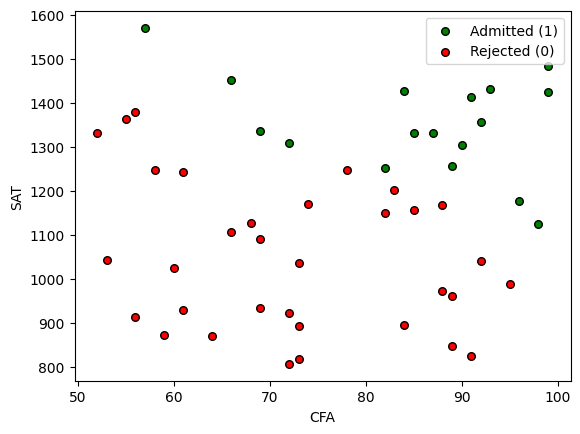

In [4]:
# TODO: Create scatter plot of CFA vs SAT, color-coded by admitted/rejected
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

**Q2:** Describe what you see. Does the data seem linearly separable?

> **Answer:**
>
>The scatter plot illustrates the accepted and rejected students with respect to their SAT and CFA scores. It appears that the accepted students are all located in the top right corner of the plot, with high CFA and high SAT scores. It also appears to be linearly separable with a negative sloped line and high y-intercept. This is expected given the linear function used to calculate the accepted/rejected labels:  accept if SAT >= -7*CFA + 1800.


---
## **Step 3: Set up network**

Initially let us use 1 layer of 1 neuron. Note that making this an array would cause the network to have multiple layers.

Set up a shallow neural network classifier using a `Pipeline(StandardScaler, MLPClassifier)`. Start with a single hidden neuron (h=1).

We have two inputs, one hidden neuron and two output neurons classes. Make a sketch of the network. You don't have to submit the sketch but it will help you understand what is going on.

In [5]:
h = 1  # one hidden neuron
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

---
## **Step 4: Properties**

Decide and record your data split ratios (e.g., Train/Val/Test = 60/20/20). Note your model properties: hidden-layer size, activation, solver, max_iter, seed.

In [6]:
# Example split replicating Train/Val/Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
X_train, X_val,  y_train, y_val  = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed, stratify=y_temp)
# (0.25 of the remaining 0.8 => 0.2)  => 60/20/20 overall

**Q3.** State your split ratios and model settings.

> **Answer:**
>
>I stuck with the 60/20/20 Train/Val/Test split. Given the fact that we are using L-BFGS, the solver will be able to converge on a solution with limited data (50 total students). This allows us to use 30 students for training, 10 students for validation, and another 10 students for testing. Other model settings include TanH activation function (bounds between -1 to 1) and 2,000 max iterations.

---
## **Step 5: Training parameters**

Confirm or adjust activation, solver, max_iter, and seed. We can change these parameters to values you prefer.

In [7]:
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=42, solver='lbfgs',
                               verbose=True))])

---
## **Step 6: Training**

Begin training by supplying the untrained model and the input/target data. Call `.fit(X_train, y_train)` on the pipeline. Keep a note of training output/any warnings.

The output is:
* `pipe`: the trained pipeline (estimator object is modified in-place, weights & biases updated).
* Training diagnostics (warnings, convergence messages) are printed if `verbose=True`.
* You can access the fitted parameters via `pipe.named_steps["clf"].coefs_` and `intercepts_`.

In [8]:
# TODO: Train the pipeline on the training data
pipe.fit(X_train, y_train)
print(f"Coefficients: {pipe.named_steps["clf"].coefs_}")
print(f"Intercept: {pipe.named_steps["clf"].intercepts_}")

Coefficients: [array([[4.43105918],
       [8.35934084]]), array([[12.51223571]])]
Intercept: [array([-4.52285399]), array([-0.19354629])]


---
## **Step 7: Understanding the Results**

Use the `metrics_at_threshold` function to evaluate your model on all three splits:

* Train set -- shows how well the model fits what it has seen.
* Validation set -- helps you judge generalization while tuning (e.g., hidden units).
* Test set -- the final, held-out check of unbiased performance.

Report accuracy at threshold = 0.5 for Train, Validation, and Test. Remember:

* Use `pipe` for the model.
* Use `X_train, y_train` for the training set.
* Use `X_val, y_val` for the validation set.
* Use `X_test, y_test` for the test set.

Plot confusion matrices for Validation and Test only (no need to plot Train, since it usually looks "too good").

Train Accuracy: 1.0
Validation Accuracy: 1.0
Test Accuracy: 1.0


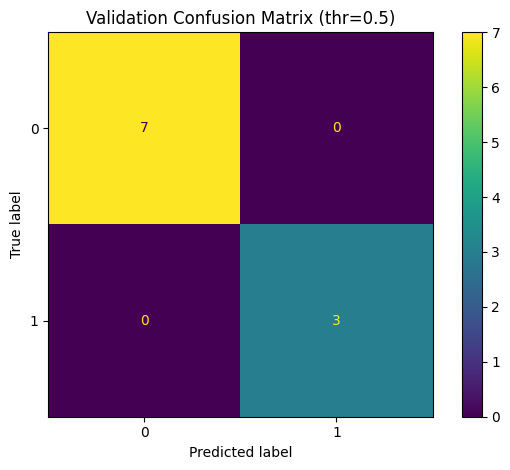

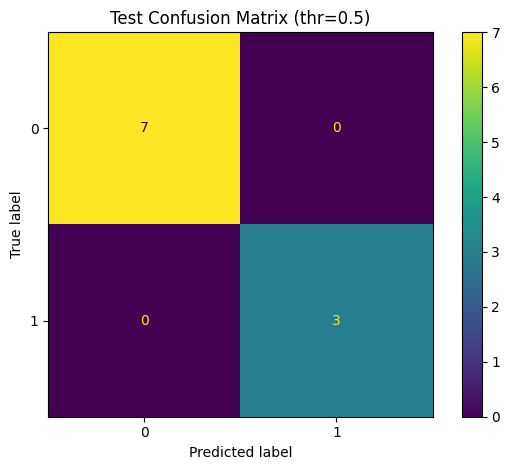

In [9]:
def metrics_at_threshold(model, Xs, ys, thr=0.5):
    p = model.predict_proba(Xs)[:,1]
    yhat = (p > thr).astype(int)
    cm = confusion_matrix(ys, yhat)
    return cm, accuracy_score(ys, yhat), precision_score(ys, yhat, zero_division=0), recall_score(ys, yhat, zero_division=0)

# TODO: Call metrics_at_threshold three times for Train, Validation, and Test
# Report accuracy @0.5 for each split
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")

val_metrics = metrics_at_threshold(pipe, X_val, y_val, 0.5)
print(f"Validation Accuracy: {val_metrics[1]}")

test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# TODO: Plot confusion matrices for Validation and Test only
cm_val, acc, prec, rec = metrics_at_threshold(pipe, X_val, y_val, 0.5)
ConfusionMatrixDisplay(cm_val).plot(); plt.title("Validation Confusion Matrix (thr=0.5)"); plt.tight_layout(); plt.show

cm_test, acc, prec, rec = metrics_at_threshold(pipe, X_test, y_test, 0.5)
ConfusionMatrixDisplay(cm_test).plot(); plt.title("Test Confusion Matrix (thr=0.5)"); plt.tight_layout(); plt.show()

**Q4.** Include confusion matrices and a brief interpretation. Report train/val/test accuracy at threshold=0.5. Write a brief interpretation: what types of errors (if any) occur on Validation and Test, and why that matters.

> **Answer:**
>
>The two confusion matrices for both the Validation and Test datasets are identical with 7 True Negatives (correctly predicted rejected), 3 True Positives (correctly predicted accepted), 0 False Negatives (incorrectly predicted rejected), and 0 False Positives (incorrectly predicted accepted). This means that the single neuron network correctly predicted its 10 student sample for both the validation and test datasets. The Train/Val/Test accuracy was all 100% at threshold=0.5 (if the model is more than 50% confident). This means that the model was 100% correct on the full dataset with zero errors. This makes sense because the dataset had zero noise and represented a linear separable distribution. So a single neuron is all that is required to perform this prediction.  

---
## **Step 8: Learnable Parameters**

Access weights and biases via `clf.coefs_` and `clf.intercepts_`. Remember: each connection (synapse) has a weight, and each neuron (in hidden and output layers) has a bias. Use the array shapes to count them.

**HINT:** General formula

For a network with:
* I = number of inputs
* O = number of outputs
* L = number of hidden layers
* H1, H2, ..., HL = number of neurons in each hidden layer

Total learnable parameters = (I x H1) + H1  +  (H1 x H2) + H2  +  ...  +  (HL x O) + O

In [10]:
# Access the trained MLPClassifier
clf = pipe.named_steps["clf"]

# Inspect weights (coefs_) and biases (intercepts_)
for i, (W, b) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print(f"Layer {i}: weights shape {W.shape}, biases shape {b.shape}")

Layer 0: weights shape (2, 1), biases shape (1,)
Layer 1: weights shape (1, 1), biases shape (1,)


**Q5:** How many weights and biases are there? What's the total number of learnable parameters? Provide a formula based on the number of inputs, outputs, hidden layers, and neurons per layer; confirm it matches your shapes.

> **Answer:**
>
>There are 3 weights and 2 biases for a total of 5 learnable parameters. I used the formula provided (I = number of inputs, O = number of outputs, L = number of hidden layers, H1 = number of neurones in hidden layer): (I x H1) + H1 + (H1 x O) + O = (2 x 1) + 1 + (1 x 1) + 1 = 5. The formula matches my shapes.

---
## **Step 9: Visualizing the decision boundary**

Use the provided code `visualize_boundary` (call with `threshold=0.5`) and **comment on its shape**. Given the data, is there a **unique "correct" boundary**?

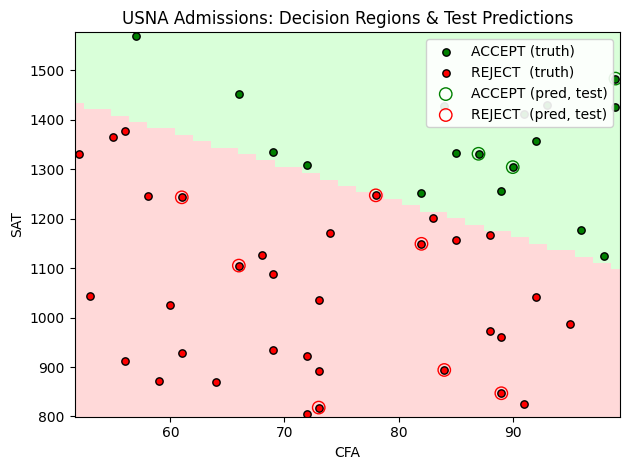

In [11]:
X_fit = np.vstack([X_train, X_val, X_test])
y_fit = np.hstack([y_train, y_val, y_test])
test_idx = np.arange(len(X_train)+len(X_val), len(X_train)+len(X_val)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

---
# **Experiment A: Importance of validation in preventing overfit**

**Create a new data set** with **Students = 100** and **Noise = 0.2** (keep your `seed` recorded).
For each configuration below, **fill in the table** after you train/evaluate:

* Threshold: **0.5** (fixed for all rows)
* Train **without** a validation set (use only **Train** and **Test** for this experiment).
    * Example split: 80% Train / 20% Test.
    * Do **not** use `X_val, y_val` here.
* Model: `Pipeline(StandardScaler, MLPClassifier)`
* Report **# learnable parameters**, **Train accuracy**, **Test accuracy**, and **Decision boundary shape** (line / curve / complex).

**Configurations (rows to run):**

1. Students 100, Noise 0.2, hiddenLayerSize = **1**
2. Students 100, Noise 0.2, hiddenLayerSize = **100**
3. Students 100, Noise 0.2, hiddenLayerSize = **[50, 50]**

Use your existing helpers:
* Generate data: `fake_admissions_data(N=100, noise_level=0.2, rng=seed)`.
* Train: `pipe.fit(X_train, y_train)` with your chosen hidden layer(s).
* Metrics @ 0.5: call `metrics_at_threshold(pipe, X_train, y_train, 0.5)` and `metrics_at_threshold(pipe, X_test, y_test, 0.5)`.
* Parameter count: read shapes from `clf = pipe.named_steps["clf"]`; sum weights (`W.size`) + biases (`b.size`) across layers.
* Boundary: `visualize_boundary(pipe, X, y, threshold=0.5)`; then label "line/curve/complex" based on what you see.
    * Note: omit `test_idx`

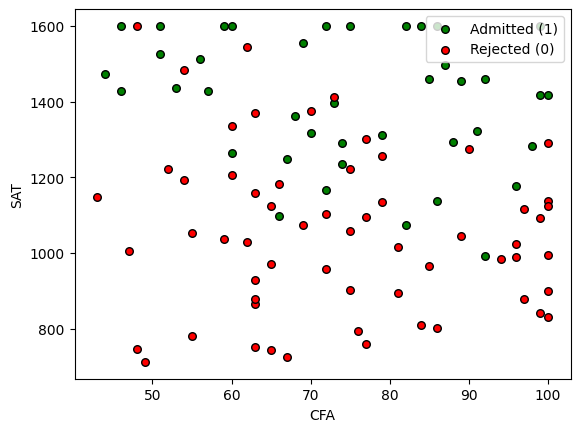

In [12]:
# TODO: Experiment A - Configuration 1: hiddenLayerSize = 1
# Generate data, split 80/20, build pipeline, train, evaluate, visualize boundary

# Create dataset
N = 100
noise_level = 0.2
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Test split (80% Train / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [13]:
# Setup network
h = 1
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=42, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 0.8125
Test Accuracy: 0.8
Layer 0: weights shape (2, 1), biases shape (1,)
Layer 1: weights shape (1, 1), biases shape (1,)


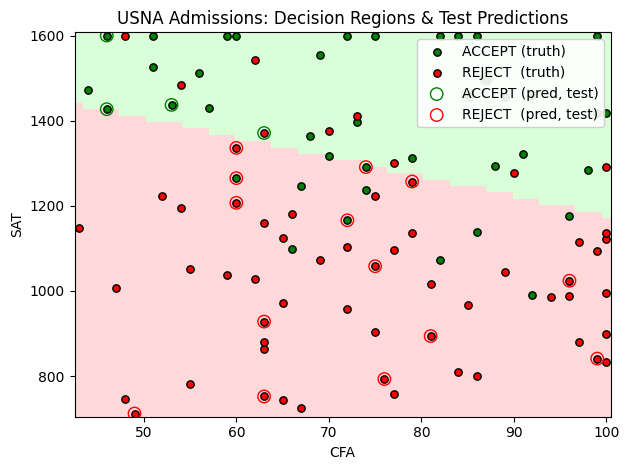

In [14]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Access the trained MLPClassifier
clf = pipe.named_steps["clf"]

# Inspect weights (coefs_) and biases (intercepts_)
for i, (W, b) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print(f"Layer {i}: weights shape {W.shape}, biases shape {b.shape}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

In [15]:
# TODO: Experiment A - Configuration 2: hiddenLayerSize = 100

# Setup network
h = 100
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', max_iter=2000,
                               random_state=42, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 0.7
Layer 0: weights shape (2, 100), biases shape (100,)
Layer 1: weights shape (100, 1), biases shape (1,)


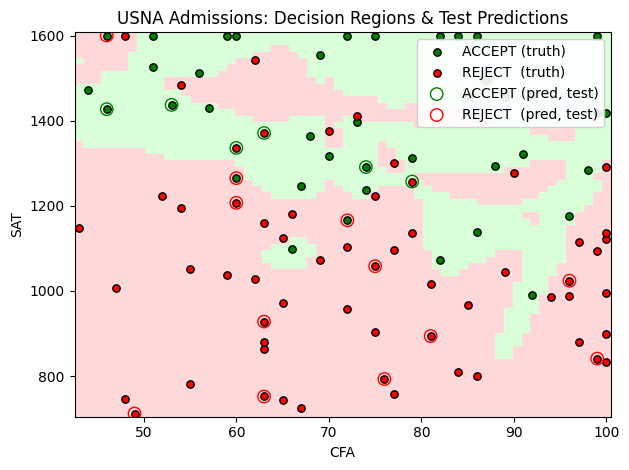

In [16]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Access the trained MLPClassifier
clf = pipe.named_steps["clf"]

# Inspect weights (coefs_) and biases (intercepts_)
for i, (W, b) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print(f"Layer {i}: weights shape {W.shape}, biases shape {b.shape}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

In [17]:
# TODO: Experiment A - Configuration 3: hiddenLayerSize = [50, 50]

# Setup network
h = [50, 50]
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=[50, 50],
                               max_iter=2000, random_state=42, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 0.75
Layer 0: weights shape (2, 50), biases shape (50,)
Layer 1: weights shape (50, 50), biases shape (50,)
Layer 2: weights shape (50, 1), biases shape (1,)


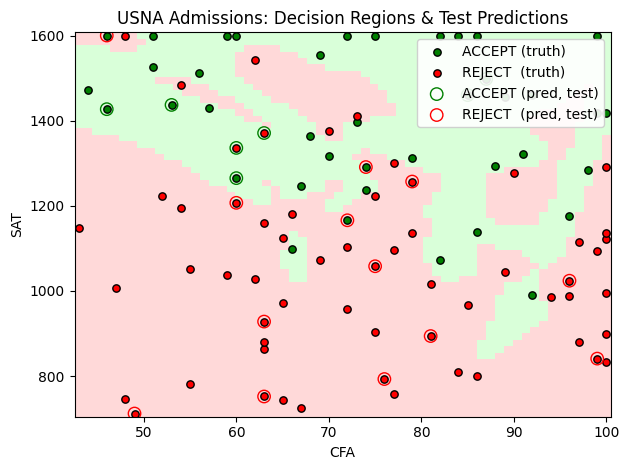

In [18]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Access the trained MLPClassifier
clf = pipe.named_steps["clf"]

# Inspect weights (coefs_) and biases (intercepts_)
for i, (W, b) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print(f"Layer {i}: weights shape {W.shape}, biases shape {b.shape}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

**Table to complete:**

| Students | Noise | hiddenLayerSize | # Learnable Parameters | Train Acc @0.5 | Test Acc @0.5 | Decision Boundary (line/curve/complex) | Notes |
| -------: | ----: | :-------------: | ---------------------: | -------------: | ------------: | :------------------------------------: | :---- |
| 100 | 0.2 | 1 | 5 | 0.8125 | 0.8 | Line | Due to the noise in the dataset, a simple linear classification would not suffice. |
| 100 | 0.2 |  100 | 401 | 1.0 | 0.7 | Complex | Adding width allows the network to learn nonlinearity, increasing the models accuracy. |
| 100 | 0.2 | [50, 50] | 2,751 | 1.0 | 0.75 | Complex | Adding depth to the network allows the model to generalize better to new data.  |

---
# **Experiment B: Even small models can overfit with high noise**

For each row in the next table perform similar steps but **reinstate the validation criteria** in Step 3.

Create a new data set with **100 students** and the noise levels below. Use a **40/10/50 Train/Val/Test split** (stratified).

Model: 1 hidden layer of **10 neurons** (`hidden_layer_sizes=(10,)`, solver="lbfgs", max_iter=2000, verbose=True).

Evaluate at threshold = 0.5.

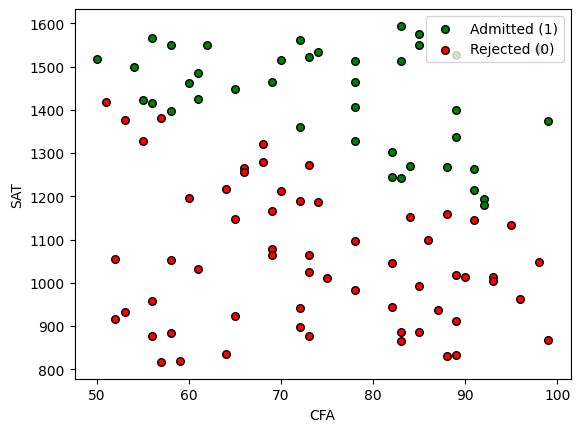

In [19]:
# TODO: Experiment B - Row 1: Noise = 0.0

# Create dataset
N = 100
noise_level = 0.0
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Val/Test split (40% Train / 10 Val / 50% Test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.50, random_state=seed, stratify=y)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=seed, stratify=y_temp)

In [20]:
# Setup network
h = 10
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(10,),
                               max_iter=2000, random_state=42, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 1.0


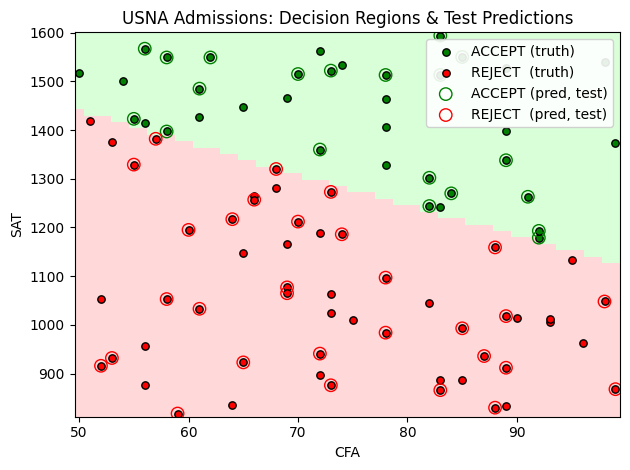

In [21]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

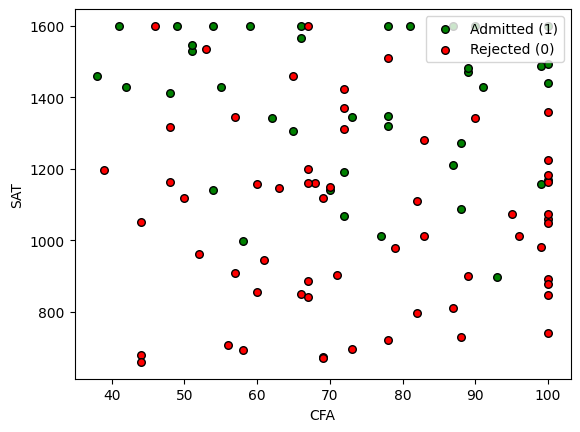

In [22]:
# TODO: Experiment B - Row 2: Noise = 0.3

# Create dataset
N = 100
noise_level = 0.3
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Val/Test split (40% Train / 10 Val / 50% Test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.50, random_state=seed, stratify=y)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=seed, stratify=y_temp)

In [23]:
# Setup network
h = 10
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(10,),
                               max_iter=2000, random_state=42, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 0.72


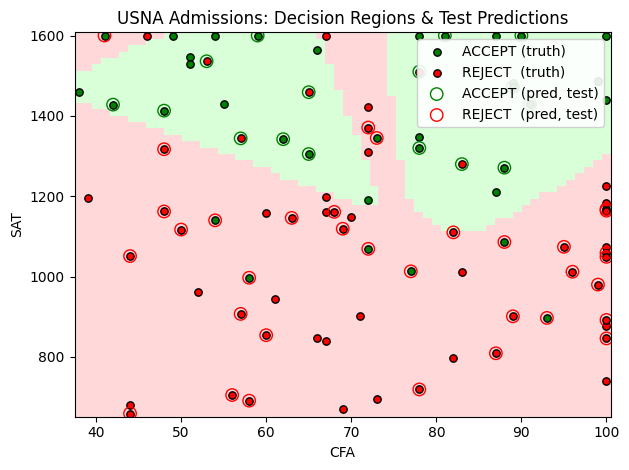

In [24]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

**Table to complete:**

| Students | Noise | hiddenLayerSize | Train Acc @0.5 | Test Acc @0.5 | Training Diagnostics -- Observation |
| -------: | ----: | :-------------: | -------------: | ------------: | :---------------------------------- |
| 100 | 0.0 | 10 | 1.0 | 1.0 | With zero noise, it’s easy for a small model to predict a perfect linear separation. |
| 100 | 0.3 | 10 | 1.0 | 0.72 | With introduced noise, the small model appears to have overfitted the data. This can be observed by the perfect training accuracy (learned the trained dataset perfectly) but failure to generalize to new data as seen by the low test accuracy and by visual observation. |

---
# **Experiment C: Repeatability is not only impacted by noise**

Vary the number of students as shown here. You will literally run the same code twice with 10 students to see how the answer varies; and then again twice with 2000 students. Make sure you change the seed for each trial (e.g., N=10, Seed 1, 2; N=2000, Seed 3, 4).

### **HINT**

* Train and use `visualize_boundary(...)` exactly as you did in Step 9.
* On the resulting plot, look at the decision boundary curve (the dividing line between green/red regions).
* Estimate the SAT value where that boundary crosses:
    * CFA = 50 (x-axis at 50) -- read the corresponding SAT on the y-axis.
    * CFA = 100 (x-axis at 100) -- read the corresponding SAT on the y-axis.
* Record those two SAT values in your table. Round to the nearest ~50 is fine.

(For comparison: the true boundary is SAT=1450 at CFA=50 and SAT=1100 at CFA=100. This is only provided so you can check whether your network boundary matches the true linear rule.)

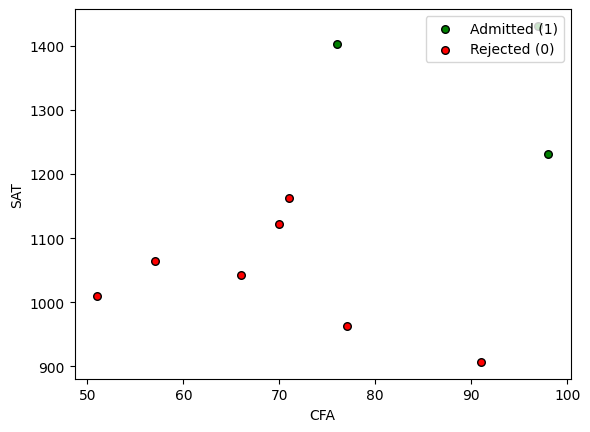

In [25]:
# TODO: Experiment C - Trial 1: N=10, Seed 1

# Create dataset
N = 10
noise_level = 0.0
seed = 1
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Test split (80% Train / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [26]:
# Setup network
h = 1
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=1, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 1.0


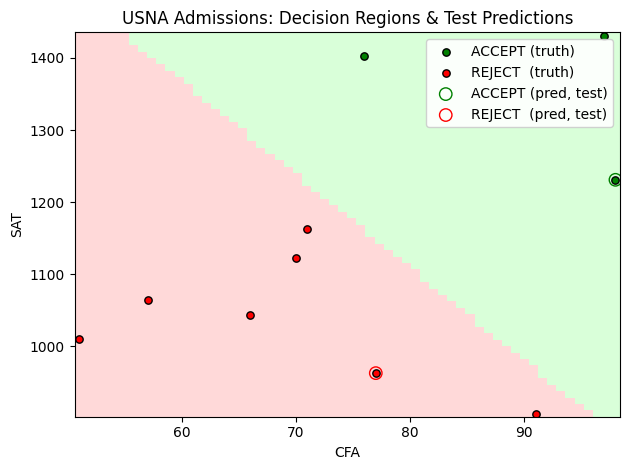

In [27]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

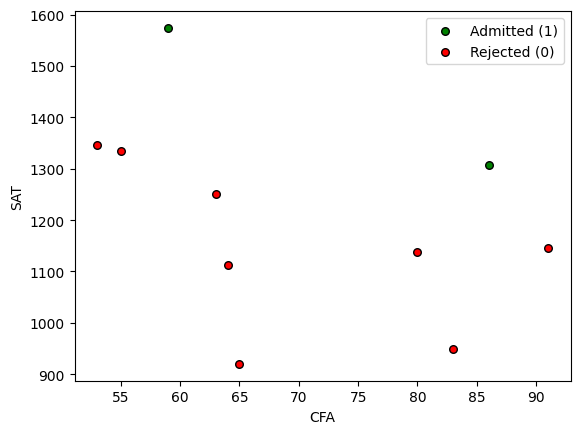

In [28]:
# TODO: Experiment C - Trial 2: N=10, Seed 2

# Create dataset
N = 10
noise_level = 0.0
seed = 2
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Test split (80% Train / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [29]:
# Setup network
h = 1
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=2, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


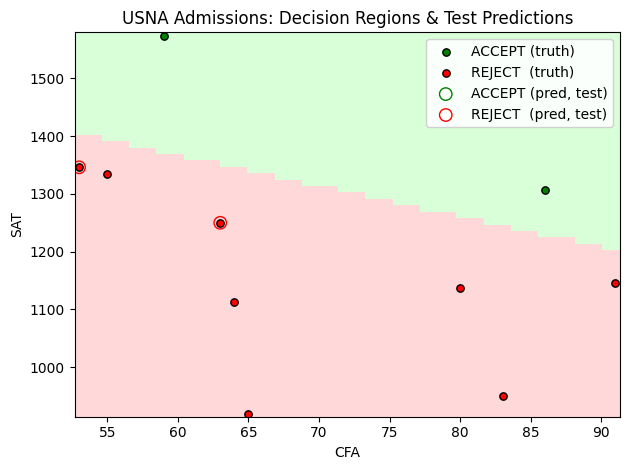

In [30]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

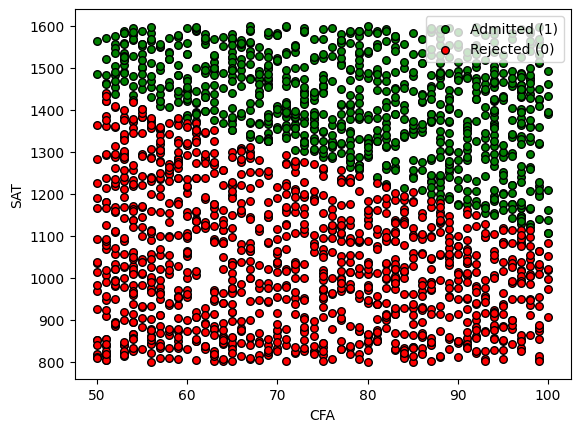

In [31]:
# TODO: Experiment C - Trial 3: N=2000, Seed 3

# Create dataset
N = 2000
noise_level = 0.0
seed = 3
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Test split (80% Train / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [32]:
# Setup network
h = 1
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=3, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 1.0
Test Accuracy: 0.9975


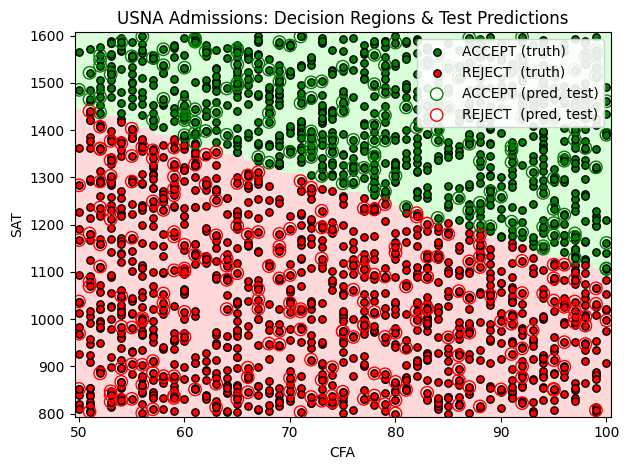

In [33]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

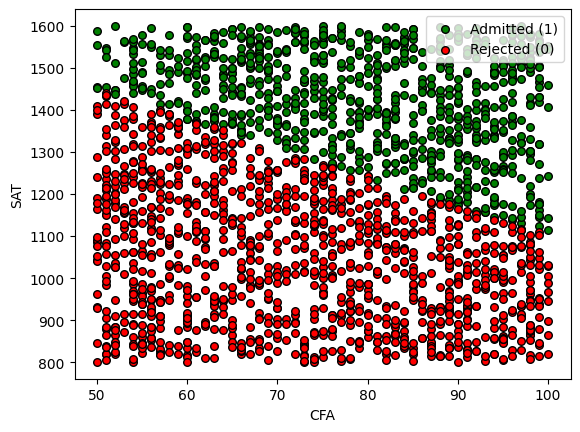

In [34]:
# TODO: Experiment C - Trial 4: N=2000, Seed 4

# Create dataset
N = 2000
noise_level = 0.0
seed = 4
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Test split (80% Train / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [35]:
# Setup network
h = 1
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=4, solver='lbfgs',
                               verbose=True))])

Train Accuracy: 0.99625
Test Accuracy: 1.0


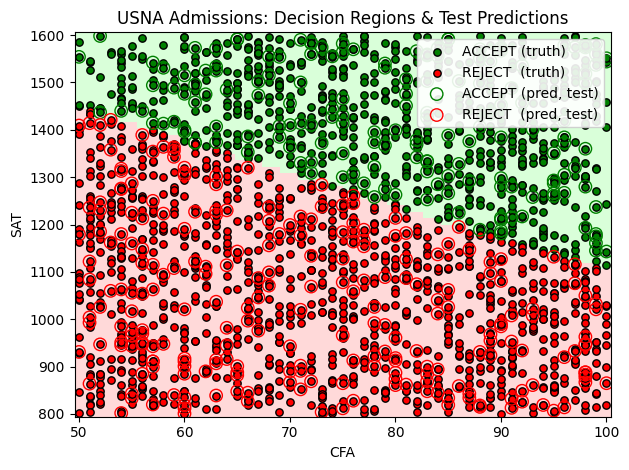

In [36]:
# Evaluate Train and Test Accuracy
train_metrics = metrics_at_threshold(pipe, X_train, y_train, 0.5)
print(f"Train Accuracy: {train_metrics[1]}")
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_fit, y_fit, threshold=0.5, test_idx=test_idx, npts=60)

**Table to complete:**

| Noise | Threshold | # Students | #Neurons | SAT @ CFA = 50 | SAT @ CFA = 100 | Train Accuracy | Test Accuracy |
| :---- | :-------- | :--------- | :------- | :-------------- | :--------------- | :------------- | :------------ |
| 0.0 | 0.5 | 10 | 1 | 1500 | 900 | 1.0 | 1.0 |
| 0.0 | 0.5 | 10 | 1 | 1450 | 1150 | 1.0 | 1.0 |
| 0.0 | 0.5 | 2000 | 1 | 1450 | 1100 | 1.0 | 0.9975 |
| 0.0 | 0.5 | 2000 | 1 | 1450 | 1150 | 0.996525 | 1.0 |

**Q6:** Discuss and compare the variability in the boundary in the 10 vs 2000 student cases.

> **Answer:**
>
>The variability between the boundary lines in the 10 and 2000 student cases was not that much. At CFA = 50, all but the first trial (SAT = 1500) shared the same SAT score of 1450 with only a 50 difference. The first trial deviated even more at CFA = 100, reporting a 900 SAT score compared to the rest of the SAT scores varying from 1150 to 1100. The large deviation in trial one was a result of lack of data points and the sample failing to represent the overall population which the 2,000 student datasets did a better job at. The consistent high Train and Test accuracy displays that the network did a perfect or near perfect job at predicting the dataset. This being said, we can conclude how randomness in the dataset, created by changing the random seed, doesn’t have a significant impact on the model’s ability to learn the population, as shown in the similarity in boundaries.

---
# **Experiment D: Threshold**

Compute the raw output (here, use `pipe.predict_proba([[CFA, SAT]])[0,1]` for e.g., `[75, 1250]`) and interpret it (not binary; it's a probability). The default threshold is 0.5, but experiment with 0.25, 0.5, 0.75. Include plots for each threshold and discuss using false positives (admitted but shouldn't be) and false negatives (rejected but should've been). Then, using test data only, complete the table: Overall Accuracy %, False Positive %, True Positive %. (Noise 0.1, Students 200, #Neurons 1.)

Remember, the **threshold** is a value that you pass into the function `metrics_at_threshold`.

Reminder:
* *True Positive Rate (TPR) = TP / (TP + FN)*
* *False Positive Rate (FPR) = FP / (FP + TN)*

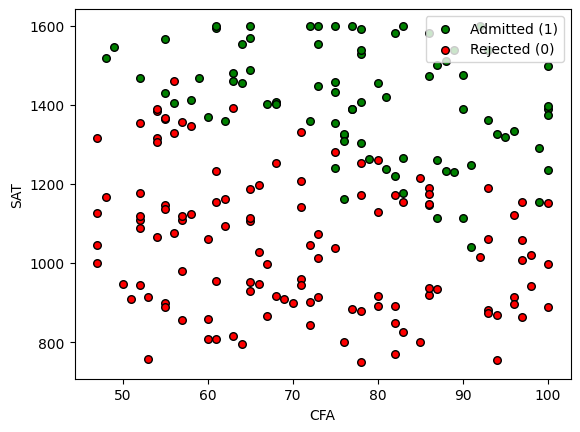

In [37]:
# TODO: Experiment D Setup - Generate data (N=200, Noise=0.1), split, train with 1 neuron

# Create dataset
N = 200
noise_level = 0.1
seed = 50
X, y = fake_admissions_data(N, noise_level, rng=seed)

# Plot distribution
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], c='g', s=30, label='Admitted (1)', edgecolor='k')
plt.scatter(X[y==0,0], X[y==0,1], c='r', s=30, label='Rejected (0)', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('CFA')
plt.ylabel('SAT')
plt.show()

# Create Train/Test split (80% Train / 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [38]:
# Setup network
h = 1
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(h,), activation='tanh',
                          solver='lbfgs', max_iter=2000, random_state=seed))
])

# Setup parameters
pipe.set_params(clf__activation='tanh',
                clf__solver='lbfgs',
                clf__max_iter=2000,
                clf__random_state=seed,
                clf__verbose=True)

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                               max_iter=2000, random_state=50, solver='lbfgs',
                               verbose=True))])

In [39]:
# TODO: Compute raw probability for a sample student [75, 1250]
pipe.predict_proba([[75, 1250]])[0,1]  # probability of "Admit"

np.float64(0.3550442074483484)

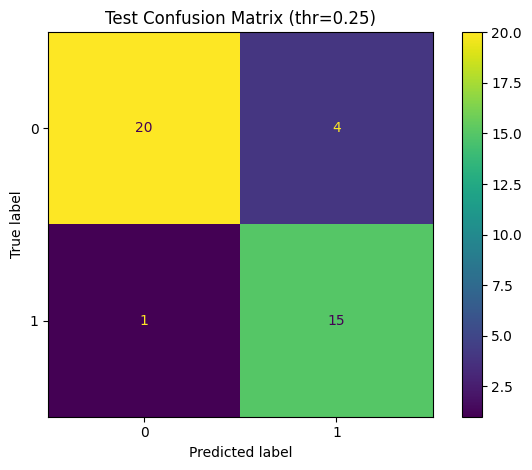

Test Accuracy: 0.875


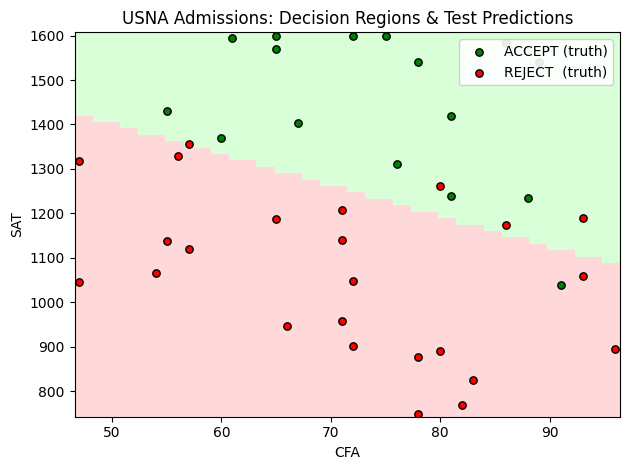

In [40]:
# TODO: Evaluate at threshold = 0.25, plot confusion matrix and decision boundary

# Plot confusion matrices
cm_test, acc, prec, rec = metrics_at_threshold(pipe, X_test, y_test, 0.25)
ConfusionMatrixDisplay(cm_test).plot(); plt.title("Test Confusion Matrix (thr=0.25)"); plt.tight_layout(); plt.show()

# Evaluate Test Accuracy
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.25)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_test, y_test, threshold=0.25, npts=60)

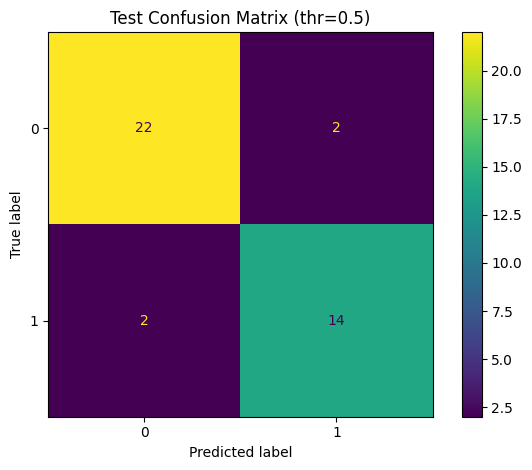

Test Accuracy: 0.9


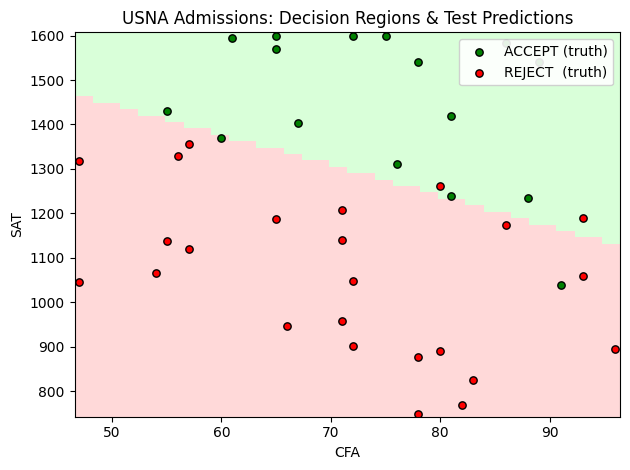

In [41]:
# TODO: Evaluate at threshold = 0.5, plot confusion matrix and decision boundary

# Plot confusion matrices
cm_test, acc, prec, rec = metrics_at_threshold(pipe, X_test, y_test, 0.5)
ConfusionMatrixDisplay(cm_test).plot(); plt.title("Test Confusion Matrix (thr=0.5)"); plt.tight_layout(); plt.show()

# Evaluate Test Accuracy
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.5)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_test, y_test, threshold=0.5, npts=60)

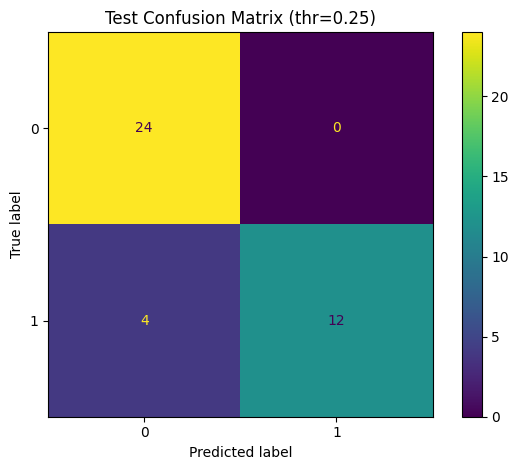

Test Accuracy: 0.9


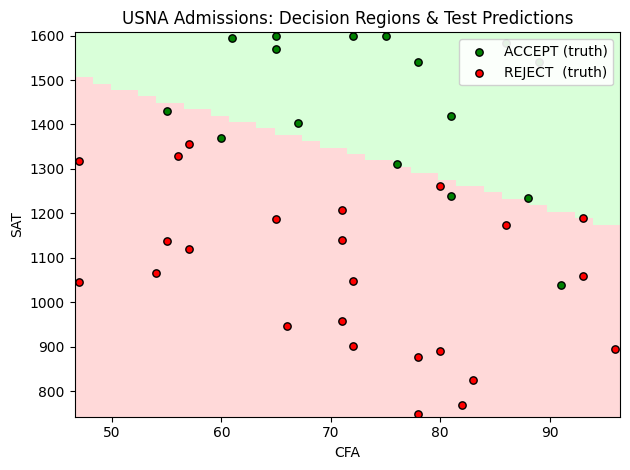

In [42]:
# TODO: Evaluate at threshold = 0.75, plot confusion matrix and decision boundary

# Plot confusion matrices
cm_test, acc, prec, rec = metrics_at_threshold(pipe, X_test, y_test, 0.75)
ConfusionMatrixDisplay(cm_test).plot(); plt.title("Test Confusion Matrix (thr=0.25)"); plt.tight_layout(); plt.show()

# Evaluate Test Accuracy
test_metrics = metrics_at_threshold(pipe, X_test, y_test, 0.75)
print(f"Test Accuracy: {test_metrics[1]}")

# Visualize boundary
X_fit = np.vstack([X_train, X_test])
y_fit = np.hstack([y_train, y_test])
test_idx = np.arange(len(X_train), len(X_train)+len(X_test))
visualize_boundary(pipe, X_test, y_test, threshold=0.75, npts=60)

**Table to complete:**

| Noise | Threshold | # Students | #Neurons | Overall Accuracy % | False Positive % | True Positive % |
| :---- | :-------- | :--------- | :------- | :----------------- | :--------------- | :-------------- |
| 0.1 | 0.25 | 200 | 1 | 87.5 | 16.7 | 93.75 |
| 0.1 | 0.5 | 200 | 1 | 90 | 8.3 | 87.5 |
| 0.1 | 0.75 | 200 | 1 | 90 | 0 | 75 |

**Q7.** Discuss how lowering vs. raising the threshold affects **false positives** and **false negatives**. What would this mean in an admissions (or mission) context?

> **Answer:**
>
>Raising the threshold tends to decrease the number of False Positives with the False Positive rate going from 16.7% for a 0.25 threshold, 8.3% for a 0.5 threshold, and 0% for a 0.75 threshold. On the other hand, lowering the threshold tends to increase the number of True Positives and decrease the number of False Negatives with the True Positive rate going from 75% for a 0.75 threshold, 87.5% for a 0.5 threshold, and 93.75% for a 0.25 threshold. For all three trials, the test accuracy remained at or above 87.5%. In the context of admissions, this strikes a tough balance. By lowering the threshold, you increase the chance of accepting a student who should have been rejected while decreasing the chance of rejecting a student who should have been accepted. Vice versa. So if the goal of admissions is to make the application process as competitive as possible and minimize the chance of accepting bad students, they should raise the threshold (at the expense of rejecting potentially good students).

---
# **Experiment E: Receiver Operator Curve (OPTIONAL)**

**Setup:**
* Use your trained model from Experiment D (Students=200, Noise=0.1, hiddenLayerSize=1).
* Instead of picking one threshold, we will examine model performance **across all thresholds**.

**Task:**
Generate and display an ROC curve for the **Test set**.

* The curve shows how the **True Positive Rate** vs. **False Positive Rate** trade off as the threshold moves from 0 to 1.
* Mark the points for thresholds you already tested in Experiment D (0.25, 0.5, 0.75).
  *(Tip: You can approximate their locations by looking at your confusion matrices and computing TPR/FPR at those thresholds.)*

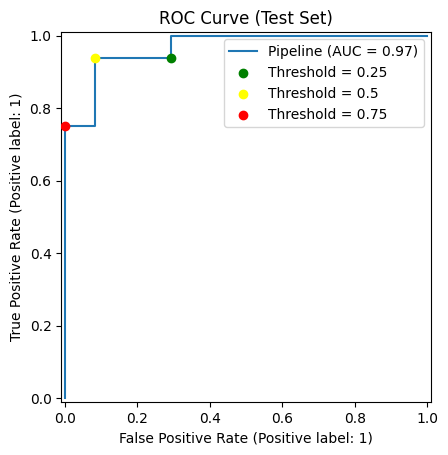

In [43]:
# TODO: Generate ROC curve for the Test set
from sklearn.metrics import RocCurveDisplay, roc_curve

# Calculate ROC curve
display = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

# Find index where threshold is closest to
idx_25 = (abs(thresholds - 0.25)).argmin()
idx_50 = (abs(thresholds - 0.5)).argmin()
idx_75 = (abs(thresholds - 0.75)).argmin()

# Plot
ax = display.ax_
ax.scatter(fpr[idx_25], tpr[idx_25], color='green', label='Threshold = 0.25', zorder=5)
ax.scatter(fpr[idx_50], tpr[idx_50], color='yellow', label='Threshold = 0.5', zorder=5)
ax.scatter(fpr[idx_75], tpr[idx_75], color='red', label='Threshold = 0.75', zorder=5)
ax.legend()
plt.title("ROC Curve (Test Set)")
plt.show()

**Q8:** Explain in 2-3 sentences how changing the threshold moves you along the ROC curve. How would you use this in a real decision-making context (e.g., balancing risk of false alarms vs. misses)?

> **Answer:**
>
>Increasing the threshold tends to move you down to the left on the ROC curve while decreasing the threshold tends to move you up and to the right on the ROC curve. This remains consistent with our previous findings where increasing the threshold tends to decrease both the True Positive rate and False Positive rate. Vice Versa. The ROC curve can help you make real life decisions when it comes to balancing risk. For example, in the context of detecting COVID-19, you would want to lower your threshold (move up and right) to maximize the number of True Positives and minimize the number of False Positives to prevent the spread of the disease.